In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Unsupervised Learning Models

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

# load the cleaned weather dataset
weather_data = pd.read_csv("../data/weather/city_data/BUDAPEST.csv")

print(weather_data.isnull().sum())
#select features for clustering excluding the date column
features = weather_data.drop(columns=['DATE','BUDAPEST_picnic_weather'],axis=1)
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)
print(normalized_features[:5])

## Determining the Optimal Number of Clusters/Components
### KMeans 

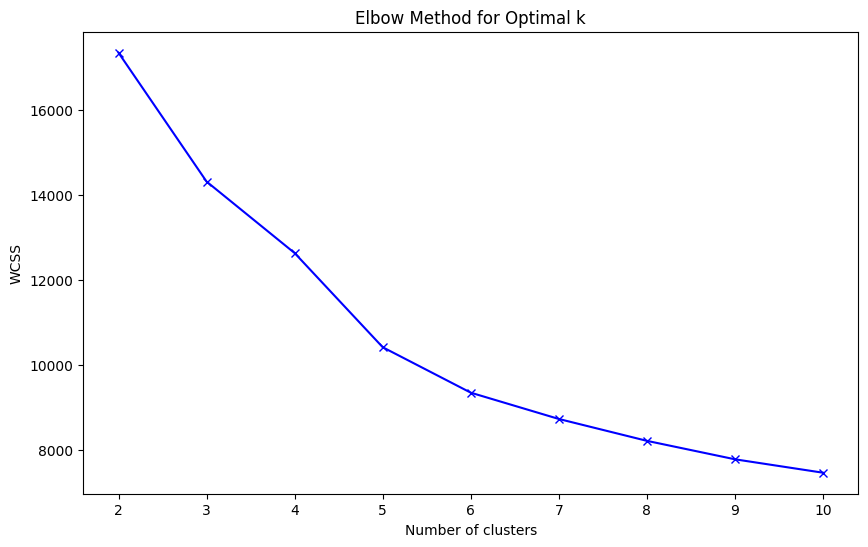

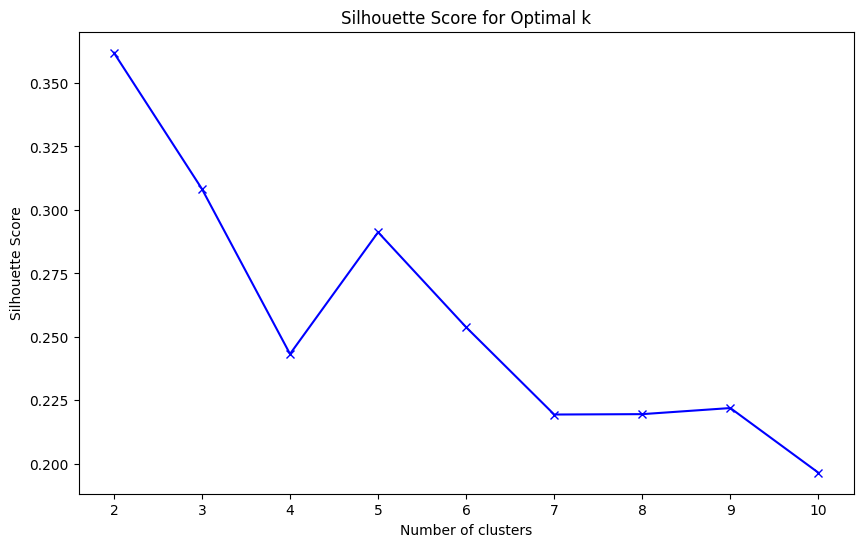

Optimal number of clusters for weather data: 2


In [4]:
from sklearn.cluster import KMeans

# function to find optimal number of clusters
def optimal_kmeans_clusters(features):
    wcss = []
    silhouette_scores = []
    cluster_range = range(2,11)
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k,random_state=42)
        kmeans.fit(features)
        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(features,kmeans.labels_))
    
    plt.figure(figsize=(10,6))
    plt.plot(cluster_range,wcss,'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.title('Elbow Method for Optimal k')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(cluster_range,silhouette_scores,'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Optimal k')
    plt.show()

    optimal_k = cluster_range[np.argmax(silhouette_scores)]
    return optimal_k

#Determining the optimal number of clusters
optimal_k = optimal_kmeans_clusters(normalized_features)
print(f'Optimal number of clusters for weather data: {optimal_k}')


### Gaussian Mixture Model (EM)

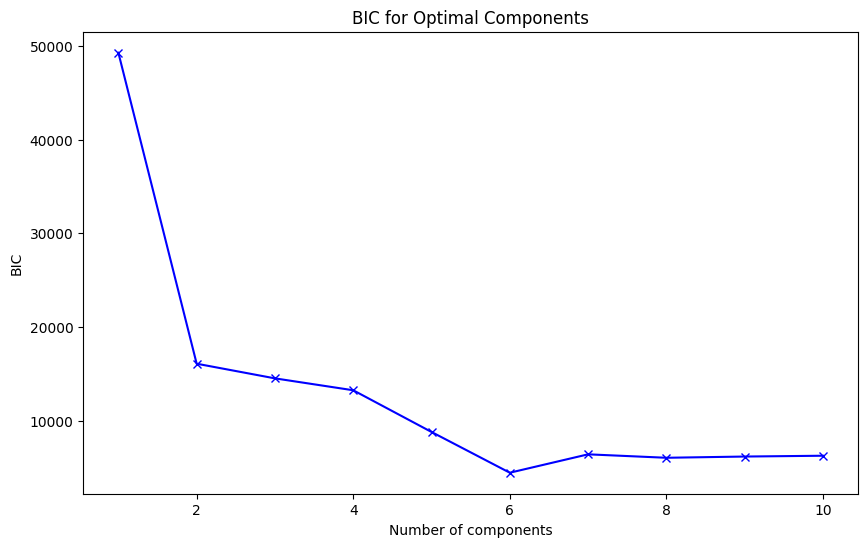

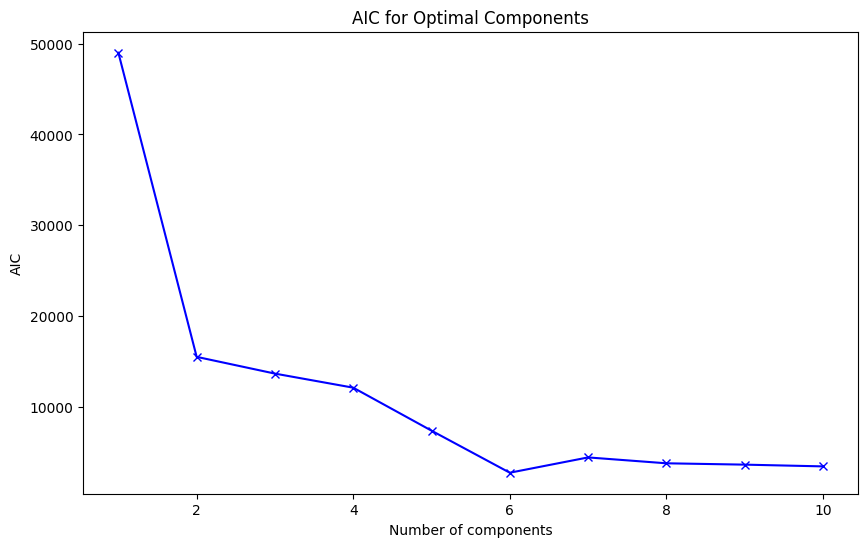

Optimal number of components for weather data using BIC: 6
Optimal number of components for weather data using AIC: 6


In [5]:
# find optimal components for GMM
def optimal_gmm_components(features):
    bic_scores = [] # Bayesian Information Criterion
    aic_scores = [] # Akaike Information Criterion
    component_range = range(1,11)
    for i in component_range:
        gmm = GaussianMixture(n_components=i,random_state=42)
        gmm.fit(features)
        bic_scores.append(gmm.bic(features))
        aic_scores.append(gmm.aic(features))
    
    plt.figure(figsize=(10,6))
    plt.plot(component_range,bic_scores,'bx-')
    plt.xlabel('Number of components')
    plt.ylabel('BIC')
    plt.title('BIC for Optimal Components')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(component_range,aic_scores,'bx-')
    plt.xlabel('Number of components')
    plt.ylabel('AIC')
    plt.title('AIC for Optimal Components')
    plt.show()

    optimal_components_bic = component_range[np.argmin(bic_scores)]
    optimal_components_aic = component_range[np.argmin(aic_scores)]
    return optimal_components_bic,optimal_components_aic

#determine the optimal number of components for GMM
optimal_components_bic,optimal_components_aic = optimal_gmm_components(normalized_features)
print(f'Optimal number of components for weather data using BIC: {optimal_components_bic}')
print(f'Optimal number of components for weather data using AIC: {optimal_components_aic}')


## Running Clustering Algorithms

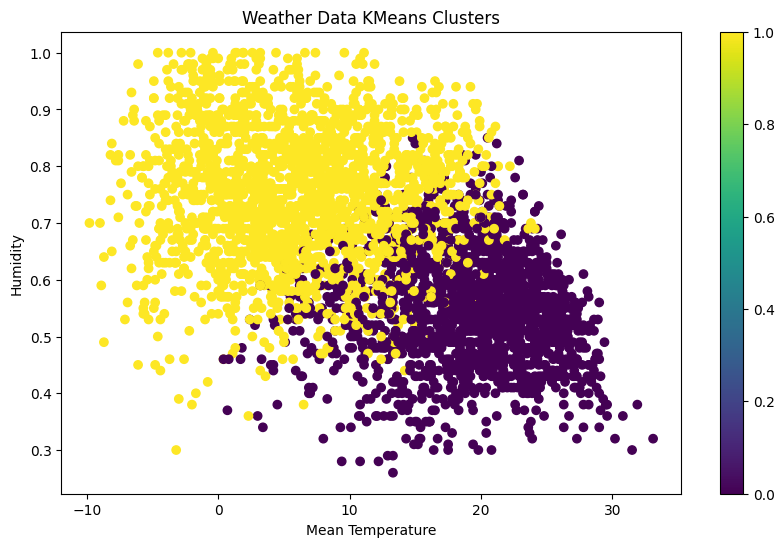

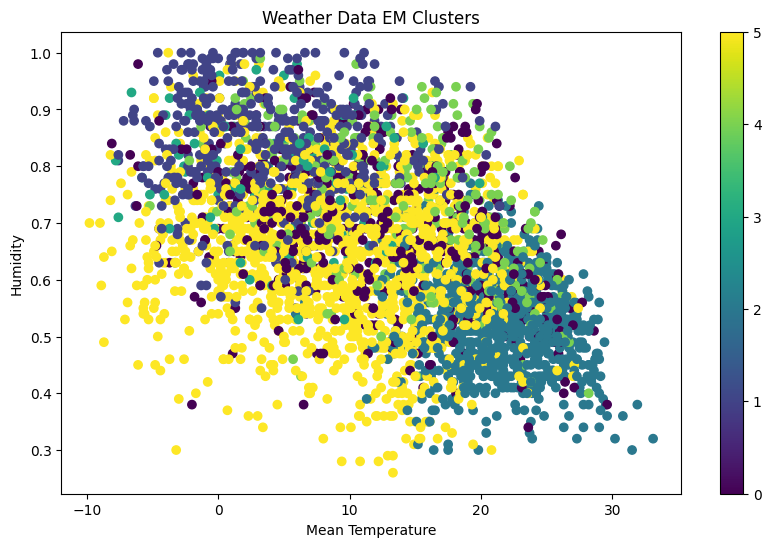

In [6]:
kmeans_weather = KMeans(n_clusters=optimal_k, random_state=42)
weather_kmeans_clusters = kmeans_weather.fit_predict(normalized_features)

# Add cluster labels to original dataset
weather_data['KMeans_Cluster'] = weather_kmeans_clusters

# Plot KMeans Clusters
plt.figure(figsize=(10, 6))
plt.scatter(weather_data['BUDAPEST_temp_mean'], weather_data['BUDAPEST_humidity'], c=weather_kmeans_clusters, cmap='viridis', marker='o')
plt.xlabel('Mean Temperature')
plt.ylabel('Humidity')
plt.title('Weather Data KMeans Clusters')
plt.colorbar()
plt.show()
# Run GMM with optimal number of components
em_weather = GaussianMixture(n_components=optimal_components_bic,random_state=42)
weather_em_clusters = em_weather.fit_predict(normalized_features)

# add the cluster labels to the original dataset
weather_data['EM_Cluster'] = weather_em_clusters

# Plot EM Clusters
plt.figure(figsize=(10, 6))
plt.scatter(weather_data['BUDAPEST_temp_mean'], weather_data['BUDAPEST_humidity'], c=weather_em_clusters, cmap='viridis', marker='o')
plt.xlabel('Mean Temperature')
plt.ylabel('Humidity')
plt.title('Weather Data EM Clusters')
plt.colorbar()
plt.show()